# Cycling Demand

![imgs](images/bikes_in_street.png)

## Table of Contents

1. Overview
2. Questions
3. Answers
4. Dependencies
5. Data
    - Overview
    - Data Prep
6. Model Training
7. Model Evaluation
8. Summary
9. Exercises

## 1. Overview

When we travel, matter where you end up around the globe, chances are that we will end up 
stopping by a city with a bikes sharing program in place. I, personally, have had the privilege 
of renting bikes by the minute in Washington DC, New York City, London, Lyon, and a few other, 
places. But, how do the governments or companies in charge of this kind of service 
- figure out where a docking station should be located at? or,
- how many bikes should each station have? or,
- how quickly will they be rented and/or replenished?
- ...

All of these are important questions, and if the person or team in charge of figuring out the answers 
is using machine learning to figure this out, chances are, a "put 10 bikes here and 20 there, trust me 
the algorithm says it" won't suffice. Context, and sometimes persuasive arguments, can go a long way.

## 2. Questions

## 3. Answers

## 4. Dependencies

In [22]:
import numpy as np
import pandas as pd
from os.path import join

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd

Here are the packages we will be using for this examples.

- `scikit-learn`
- `pandas`
- `joblib`
- `matplotlib`
- `alibi`

## 5. Data

In [23]:
data_path = join('data', 'cycling')

In [24]:
df = pd.read_csv(join(data_path, 'london_merged.csv'))
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [102]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [103]:
# extract feature names
feature_names = df.columns.tolist()
feature_names.remove('cnt')

In [104]:
feature_names

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'days_since_2011']

In [105]:
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices   = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]
categorical_columns_indices, numerical_columns_indices

([0, 1, 2, 3, 4, 5, 6], [7, 8, 9, 10])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], df['cnt'], test_size=0.2, random_state=0
)

In [107]:
X_train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,SPRING,2011,APR,NO HOLIDAY,FRI,WORKING DAY,MISTY,7.784151,83.6250,15.208464,97
503,SPRING,2012,MAY,NO HOLIDAY,FRI,WORKING DAY,GOOD,18.515849,52.3333,9.166739,503
642,FALL,2012,OCT,NO HOLIDAY,THU,WORKING DAY,MISTY,22.902500,72.2917,7.875582,642
498,SPRING,2012,MAY,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,20.787500,57.6250,15.082839,498
303,FALL,2011,OCT,NO HOLIDAY,MON,WORKING DAY,GOOD,7.980000,70.3333,7.125450,303


In [108]:
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])
oe

OrdinalEncoder()

In [109]:
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names]  = oe.transform(X_test[categorical_columns_names])

In [110]:
X_train[categorical_columns_names].head()

,season,yr,mnth,holiday,weekday,workingday,weathersit
97,1.0,0,0.0,1.0,0.0,1.0,1.0
503,1.0,1,8.0,1.0,0.0,1.0,0.0
642,0.0,1,10.0,1.0,4.0,1.0,1.0
498,1.0,1,8.0,1.0,3.0,0.0,0.0
303,0.0,0,10.0,1.0,1.0,1.0,0.0


In [111]:
X_train[categorical_columns_names].info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 97 to 684
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      584 non-null    object
 1   yr          584 non-null    int64 
 2   mnth        584 non-null    object
 3   holiday     584 non-null    object
 4   weekday     584 non-null    object
 5   workingday  584 non-null    object
 6   weathersit  584 non-null    object
dtypes: int64(1), object(6)
memory usage: 36.5+ KB


In [112]:
oe.categories_

[array(['FALL', 'SPRING', 'SUMMER', 'WINTER'], dtype=object),
 array([2011, 2012]),
 array(['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY',
        'NOV', 'OCT', 'SEP'], dtype=object),
 array(['HOLIDAY', 'NO HOLIDAY'], dtype=object),
 array(['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'], dtype=object),
 array(['NO WORKING DAY', 'WORKING DAY'], dtype=object),
 array(['GOOD', 'MISTY', 'RAIN/SNOW/STORM'], dtype=object)]

In [113]:
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}
categorical_names

{0: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
 1: [2011, 2012],
 2: ['APR',
  'AUG',
  'DEC',
  'FEB',
  'JAN',
  'JUL',
  'JUN',
  'MAR',
  'MAY',
  'NOV',
  'OCT',
  'SEP'],
 3: ['HOLIDAY', 'NO HOLIDAY'],
 4: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
 5: ['NO WORKING DAY', 'WORKING DAY'],
 6: ['GOOD', 'MISTY', 'RAIN/SNOW/STORM']}

In [115]:
# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)
cat_transf

OneHotEncoder(categories=[range(0, 4), range(0, 2), range(0, 12), range(0, 2),
                          range(0, 7), range(0, 2), range(0, 3)],
              handle_unknown='ignore')

In [116]:
# define numerical standard sclaer
num_transf = StandardScaler()

StandardScaler()

In [118]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)

In [119]:
# fit preprocessor
preprocessor.fit(X_train.values)

ColumnTransformer(sparse_threshold=0,
                  transformers=[('cat',
                                 OneHotEncoder(categories=[range(0, 4),
                                                           range(0, 2),
                                                           range(0, 12),
                                                           range(0, 2),
                                                           range(0, 7),
                                                           range(0, 2),
                                                           range(0, 3)],
                                               handle_unknown='ignore'),
                                 [0, 1, 2, 3, 4, 5, 6]),
                                ('num', StandardScaler(), [7, 8, 9, 10])])

In [120]:
X_train_ohe = preprocessor.transform(X_train.values)
X_test_ohe  = preprocessor.transform(X_test.values)
X_train_ohe.shape, X_train_ohe[:2, :]

((584, 36),
 array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          1.        ,  0.        , -0.84514833,  1.51736496,  0.49077526,
         -1.25834614],
        [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
   

## 6. Model Training

In [121]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f'  % (predictor.score(X_test_ohe,  y_test)))

Train score: 0.98
Test score: 0.90


In [122]:
from sklearn.pipeline import Pipeline

In [123]:
pipe = Pipeline([('preprocess', preprocessor), ('model', predictor)])
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories=[range(0, 4),
                                                                            range(0, 2),
                                                                            range(0, 12),
                                                                            range(0, 2),
                                                                            range(0, 7),
                                                                            range(0, 2),
                                                                            range(0, 3)],
                                                                handle_unknown='ignore'),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('num', StandardScaler(),
                                                  [7, 8, 9, 10])])),
                ('model', RandomForestRegressor(random_state=0))])

## 7. Model Evaluation

Partial dependence plots (PDPs) are a great way to understand how machine learning 
models work. Let me explain step-by-step with an analogy:

Imagine you have a model that predicts house prices based on size, location, etc. You 
want to know - how does size affect the predicted price?

Step 1: Fix all the other features except size. So keep location, number of bedrooms, etc. the 
same. 

Step 2: Feed the model different values for size only, keeping everything else fixed. Record 
the predicted price for each size value.

This is like asking: "If I only change the size, how would that impact the predicted price?"

Step 3: Plot the size values versus the predicted prices. The curve shows the partial 
dependence of price on size.

An analogy is baking a cake. To understand how egg amount affects cake taste:

1. Fix the flour, sugar, etc. amounts 
2. Bake cakes varying only the egg amount
3. Plot taste vs. egg amount 

The curve illustrates the partial dependence of taste on eggs specifically.

So in essence, partial dependence isolates one feature to study its marginal effect 
on predictions. By ignoring interactions with other features, we can better understand 
each feature's individual relationship with the target.

In [126]:
# define explainer
explainer = PartialDependence(
    predictor=pipe.predict, feature_names=feature_names, 
    target_names=['Number of bikes'], categorical_names=categorical_names
)

In [127]:
# select temperature, humidity, wind speed, and season
features = [feature_names.index('temp'),
            feature_names.index('hum'),
            feature_names.index('windspeed'),
            feature_names.index('season')]

In [128]:
X_train

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,1.0,0,0.0,1.0,0.0,1.0,1.0,7.784151,83.6250,15.208464,97
503,1.0,1,8.0,1.0,0.0,1.0,0.0,18.515849,52.3333,9.166739,503
642,0.0,1,10.0,1.0,4.0,1.0,1.0,22.902500,72.2917,7.875582,642
498,1.0,1,8.0,1.0,3.0,0.0,0.0,20.787500,57.6250,15.082839,498
303,0.0,0,10.0,1.0,1.0,1.0,0.0,7.980000,70.3333,7.125450,303
...,...,...,...,...,...,...,...,...,...,...,...
707,0.0,1,2.0,1.0,2.0,0.0,1.0,9.938349,91.1250,6.792393,707
192,2.0,0,5.0,1.0,5.0,1.0,0.0,29.325849,55.9167,13.417018,192
629,2.0,1,11.0,1.0,0.0,1.0,0.0,20.160849,66.8750,10.333343,629
559,2.0,1,5.0,1.0,0.0,1.0,1.0,26.388349,48.5833,5.416950,559


In [129]:
X_train.values

array([[1.0, 0, 0.0, ..., 83.625, 15.208464, 97],
       [1.0, 1, 8.0, ..., 52.3333, 9.166739, 503],
       [0.0, 1, 10.0, ..., 72.2917, 7.875582, 642],
       ...,
       [2.0, 1, 11.0, ..., 66.875, 10.333343, 629],
       [2.0, 1, 5.0, ..., 48.5833, 5.41695, 559],
       [0.0, 1, 9.0, ..., 62.0417, 10.250129, 684]], dtype=object)

In [130]:
# compute explanations
exp = explainer.explain(X=X_train.values,
                        features=features,
                        kind='average')

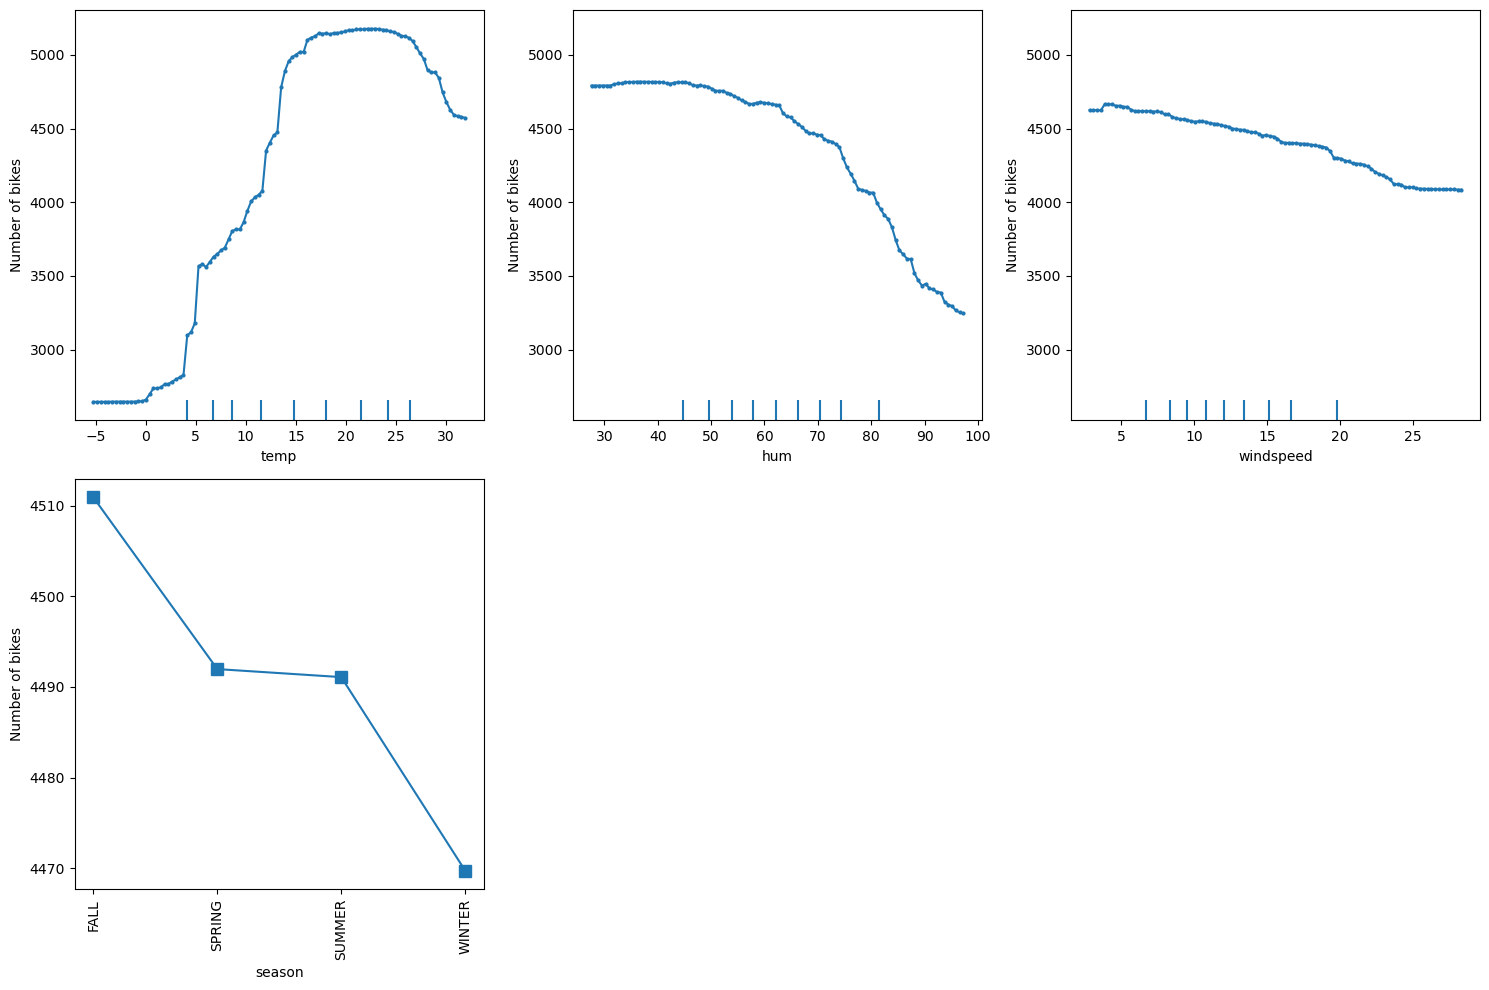

In [131]:
# plot partial dependece curves
plot_pd(exp=exp,
        n_cols=3,
        sharey='row',
        fig_kw={'figheight': 10, 'figwidth': 15});

In [132]:
# compute explanations
exp = explainer.explain(X=X_train.values,
                        features=features,
                        kind='both')

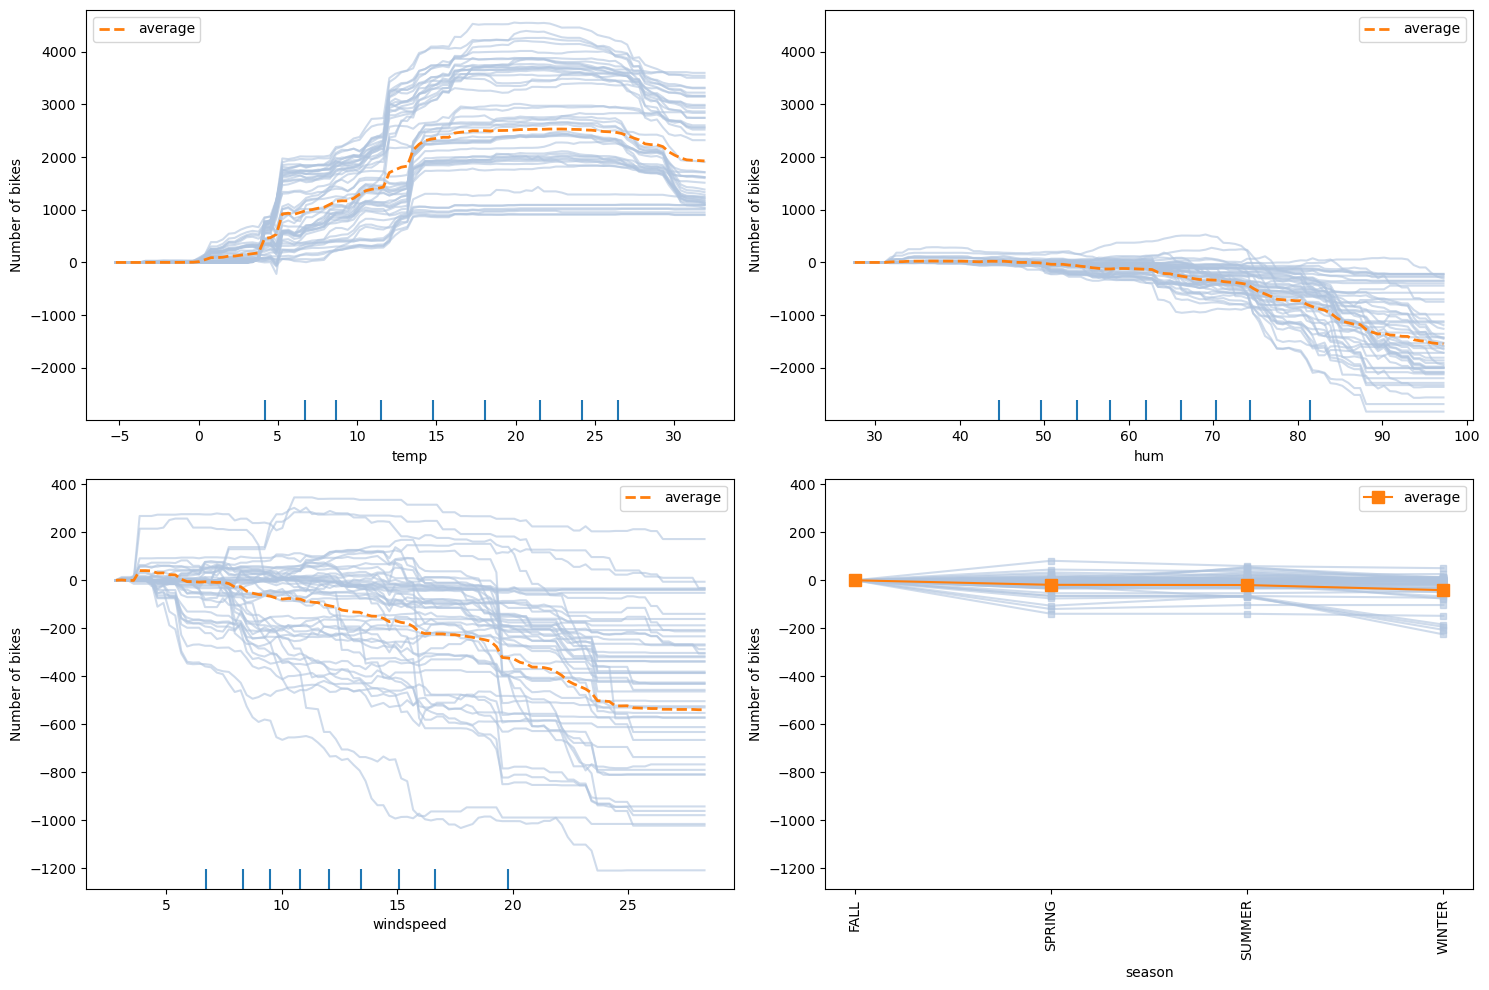

In [133]:
# random seed for `ice` sampling
np.random.seed(13)

# plot the pd and ice
plot_pd(exp=exp,
        n_cols=2,
        n_ice=50,   # number of ICE curves to be displayed. Can be set to 'all' or provided a list of indices
        sharey='row',
        center=True,  # center the plots for better visualization
        fig_kw={'figheight': 10, 'figwidth': 15});

In [134]:
features = [
    (feature_names.index('temp'), feature_names.index('windspeed')),
    (feature_names.index('mnth'), feature_names.index('weathersit')),
    (feature_names.index('season'), feature_names.index('temp'))
]

In [135]:
# compute explanations
exp = explainer.explain(X=X_train.values,
                        features=features,
                        kind='average',
                        grid_resolution=25)

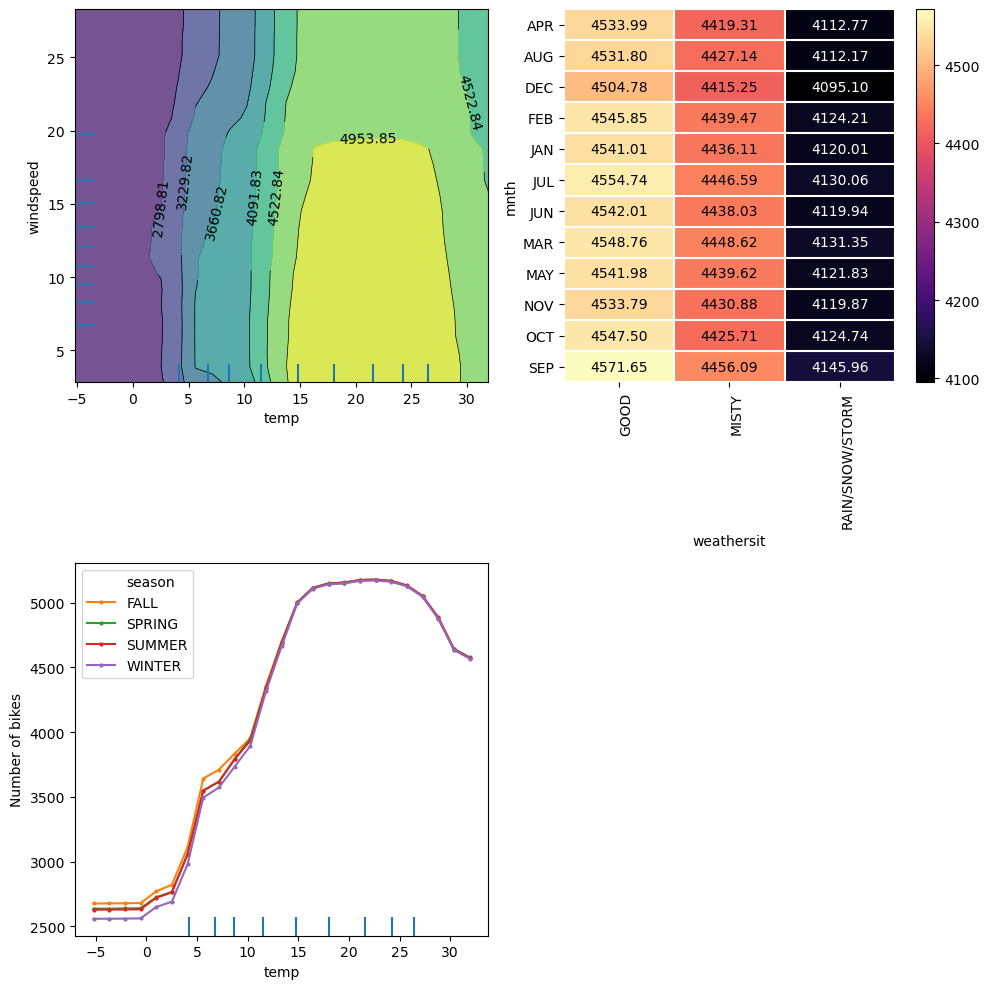

In [136]:
# plot partial dependece curves
plot_pd(exp=exp,
        n_cols=2,
        fig_kw={'figheight': 10, 'figwidth': 10});

## 8. Conclusion